In [17]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import scipy.sparse.linalg as linalg
import pickle
from sensors import utils

In [39]:
G, flows, speeds = utils.data.read_traffic_data("sdc")

## Proposed

In [40]:
from sensors.smooth.smoothprediction import speed_prediction

In [41]:
def transition_matrix(G):
    A = np.array(nx.adjacency_matrix(G).todense())
    D_inv = np.diag([1 / x for x in np.sum(A, axis=0)])
    return np.dot(D_inv, A)

def weightedL2(a, b, w):
    q = a-b
    return (w*q*q).sum()

In [ ]:
from scipy import sparse
import random
from tqdm.notebook import tqdm

def choose_sensors_sparse(G, labeled_edges, weights=None, ratio=0.1, debug=False):  
    if weights == None:
        weights = {e: 1 for e in labeled_edges}
    
    k = int(ratio * len(labeled_edges))
    m = G.number_of_edges()
    
    # Relabel edges to 1, 2, ..., m
    line_G = nx.line_graph(G)
    mapping = dict(zip(line_G.nodes(), range(m)))
    reverse = dict(zip(range(m), line_G.nodes()))
    nx.relabel_nodes(line_G, mapping, copy=False)
    
    if debug:
        print("relabeled edges")
    
    # Create true signal and weight vectors
    x = np.zeros(m)
    w = np.zeros(m)
    for e, s in labeled_edges.items():
        x[mapping[e]] = s 
        w[mapping[e]] = weights[e]
        
    if debug:
        print("created signal and weight vectors")
    
    # Choose random sensors
    C = [mapping[e] for e in labeled_edges]
    S = random.sample(C, k)
    T = sorted(list(set(line_G.nodes()) - set(S)))
    
    # Initial prediction
    P = sparse.csc_matrix(transition_matrix(line_G))
    P_TT = P[np.ix_(T, T)]
    P_TS = P[np.ix_(T, S)]

    lu = sparse.linalg.splu(sparse.identity(m-k, format="csc") - P_TT)
    
    if debug:
        print("computed LU decomposition")

    x_S = x[np.ix_(S)]
    x_T_hat = lu.solve(P_TS @ x_S)
    
    current_err = weightedL2(x_T_hat, x[np.ix_(T)], w[np.ix_(T)])
    old_err = float("inf")
    iteration = 0
    
    if debug:
        print("beginning search")
    
    while old_err - current_err > 1e-5:
        old_err = current_err
        
        if debug:
            print("iteration {} current error {:e}".format(iteration, current_err))
        
        for i in tqdm(range(k)):
            # Move sensor i to a more optimal placement
            candidates = random.sample(list(set(C).difference(set(S))), min(10, len(C) - len(S)))
            
            for v in candidates:
                S_prime = S[:i] + [v] + S[i+1:]
                swap = np.where(np.array(T) == v)[0][0]
                T_prime = T[:swap] + [S[i]] + T[swap+1:]
                
                P_TT_prime = P[np.ix_(T_prime, T_prime)]
                
                P_TS_prime = P[np.ix_(T_prime, S_prime)]
                x_S_prime = x[np.ix_(S_prime)]
                
                U = np.zeros((m-k, 2))
                U[:, 1] = P_TT.toarray()[:, swap] - P_TT_prime.toarray()[:, swap]
                U[swap] = [1, 0]
                
                V = np.zeros((2, m-k))
                V[0] = P_TT.toarray()[swap] - P_TT_prime.toarray()[swap]
                V[:, swap] = [0, 1]
                
                x_int = lu.solve(P_TS_prime @ x_S_prime)
                Y = lu.solve(U)
                
                # the sparse version
                x_int = sparse.csc_array(x_int).transpose()
                Y = sparse.csc_matrix(Y)
                V = sparse.csc_matrix(V)
                I = sparse.identity(2, format="csc")
                x_T_prime_sparse = x_int - Y @ sparse.linalg.inv(I + V @ Y) @ V @ x_int
                
                # If error decreased, keep the swap
                new_err = weightedL2(x_T_prime_sparse.transpose().toarray(), x[np.ix_(T_prime)], w[np.ix_(T_prime)])
                if new_err < current_err:
                    if debug:
                        print("swapping nodes, recomputing LU decomposition...", end="")
                        
                    # New sensor and target sets
                    current_err = new_err
                    S = S_prime
                    T = T_prime
                    P_TT = P_TT_prime
                    
                    # Recompute LU decomposition
                    lu = sparse.linalg.splu(sparse.identity(m-k, format="csc") - P_TT)
                    
                    if debug:
                        print("done")
                        
        if debug:
            print("end of iteration {} improvement {:e}".format(iteration, old_err - current_err))
        iteration += 1
    return [reverse[s] for s in S]

sensors = choose_sensors_sparse(G, speeds, ratio=.5)

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

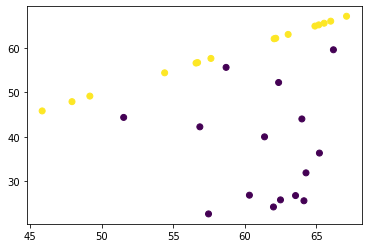

In [34]:
import matplotlib.pyplot as plt

pred = speed_prediction(G, {s: speeds[s] for s in sensors})
plt.scatter(*list(zip(*[(speeds[e], pred[e]) for e in speeds])), c = [1 if e in sensors else 0 for e in speeds])

In [35]:
{s: speeds[s] for s in sensors}

{(1613371752, 31479975): 65.18241808425618,
 (268537917, 268537918): 65.55901929444,
 (269459231, 269459232): 66.01933439890398,
 (4055678331, 363429201): 57.63590592533394,
 (540985730, 540985718): 64.9146249571869,
 (269459341, 269459342): 47.91113140769494,
 (326711425, 38454746): 62.05949309281881,
 (4055678332, 250056463): 56.59239639228223,
 (268538960, 268538962): 49.160624999999996,
 (69004190, 268539659): 56.7015869391483,
 (68267437, 20972370): 45.82329032994634,
 (1347515636, 268538952): 54.395833333333336,
 (2358067017, 2358067025): 67.12648704189976,
 (269459230, 269459231): 62.171172508277195,
 (269460920, 353033055): 63.0398504395479}

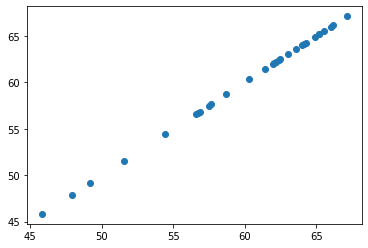

In [36]:
plt.scatter(*list(zip(*[(speeds[e], speeds[e]) for e in speeds])))

In [38]:
np.corrcoef(np.array([pred[e] for e in speeds]), np.array(list(speeds.values())))

array([[1.        , 0.11090519],
       [0.11090519, 1.        ]])

## Error Minimization

Baseline from http://hanj.cs.illinois.edu/pdf/icdm12_qgu.pdf

In [ ]:
line_G = nx.line_graph(G.to_undirected())

In [ ]:
from tqdm.notebook import tqdm

def choose_errormin_sensors(G, ratio, C=None):    
    line_G = nx.line_graph(G.to_undirected())
    n = line_G.number_of_nodes()
    mu = 0.01

    L = nx.normalized_laplacian_matrix(line_G).toarray()
    eigenvalues, U = np.linalg.eigh(L)
    Lambda_inv = np.diag([1 / max(lam, 1e-6) for lam in eigenvalues])

    Gamma_inv = np.zeros((n, n))
    for i in range(n):
        if eigenvalues[i] > 1e-6: 
            Gamma_inv[i][i] = 1 / ((mu * eigenvalues[i] + 1) ** 2 - 1) ** 2
        else:
            Gamma_inv[i][i] = 1 / ((mu * 1e-6 + 1) ** 2 - 1) ** 2
            
    Gamma = np.zeros((n, n))
    for i in range(n):
        Gamma[i][i] = 1 / Gamma_inv[i][i]
            
    l = int(G.number_of_nodes() * ratio)
    sensors = []
    H_inv = Gamma_inv
    for k in tqdm(range(l)):
        idx, s, opt = None, None, -1 * float("inf")
        for i, e in enumerate(line_G.nodes()):
            if e not in sensors and e in C:
                u_e = U[i].transpose().reshape(U.shape[0], 1)
                val = (u_e.transpose() @ H_inv @ Lambda_inv @ H_inv @ u_e) / (1 + u_e.transpose() @ H_inv @ u_e)
                if val > opt:
                    idx, s, opt = i, e, val

        sensors.append(s)
        print(idx, U[idx].T.shape)
        u_s = U[idx].transpose().reshape(U.shape[0], 1)    
        H_inv = H_inv - (H_inv @ u_s @ u_s.transpose() @ H_inv) / (1 + u_s.transpose() @ H_inv @ u_s)
        
    return sensors

In [ ]:
sensors = choose_errormin_sensors(G, 0.1, C=flows.keys())

In [ ]:
pred = speed_prediction(G, {s: flows[s] for s in sensors})
np.corrcoef(np.array(list(pred.values())), np.array(list(signal.values())))

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(list(signal.values()), list(pred.values()), c = [1 if e in sensors else 0 for e in signal])

## Sampling

In [ ]:
def choose_sampling_sensors(G, ratio, param=4, C=None):
    line_G = nx.line_graph(G.to_undirected())
    m = line_G.number_of_nodes()
    if C == None:
        C = set(line_G.nodes())
    
    mapping = dict(zip(line_G.nodes(), range(m)))
    reverse = dict(zip(range(m), line_G.nodes()))
    nx.relabel_nodes(line_G, mapping, copy=False)
    
    L_k = np.linalg.matrix_power(nx.normalized_laplacian_matrix(line_G).toarray(), param)
        
    S = []
    
    for i in range(int(m * ratio)):
        S_complement = list(set(line_G.nodes()) - set(S))
        eigenvalues, eigenvectors = np.linalg.eigh(L_k[np.ix_(S_complement, S_complement)])
        
        opt = np.argmax(eigenvectors[:, 0].transpose() * eigenvectors[:, 0])     
        S.append(S_complement[opt])
             
    return [reverse[s] for s in S]

sensors = choose_sampling_sensors(G, .1, 4)

In [ ]:
pred = speed_prediction(G, {s: signal[s] for s in sensors})
plt.scatter(list(signal.values()), list(pred.values()), c = [1 if e in sensors else 0 for e in signal])

In [ ]:
np.corrcoef(np.array(list(pred.values())), np.array(list(signal.values())))

## Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

def choose_spectral_sensors(G, ratio):
    line_graph = nx.line_graph(G.to_undirected(), create_using=nx.Graph())
    k = int(ratio * line_graph.number_of_nodes())
    
    A = nx.to_numpy_array(line_graph)
    sc = SpectralClustering(n_clusters=k, assign_labels='discretize', affinity='precomputed', random_state=0).fit(A)
    membership = sc.labels_
    nodes = list(line_graph.nodes())
    selected = []
    
    for i in range(k):
        part = np.argwhere(np.array(membership) == i).ravel()

        #selecting a random node in the partition
        if len(part) > 0:
            selected.append(np.random.choice(part))
        else:
            selected.append(np.random.choice(list(set(range(len(membership))) - set(selected))))
                
    return [nodes[u] for u in selected]

sensors = choose_spectral_sensors(G, 0.1)

In [ ]:
pred = speed_prediction(G, {s: signal[s] for s in sensors})
plt.scatter(list(signal.values()), list(pred.values()), c = [1 if e in sensors else 0 for e in signal])

In [ ]:
np.corrcoef(np.array(list(pred.values())), np.array(list(signal.values())))

## Experiments

In [ ]:
from sensors import dict2vect

def err(G, sensors, labels, i, error):
    preds = speed_prediction(G, {s: labels[s] for s in sensors[:i]})
    return error(preds, labels)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def flow_weighted_corr(G, flows):
    return lambda preds, labels: corr(dict2vect(G, preds), dict2vect(G, labels), dict2vect(G, flows))

In [ ]:
from tqdm.notebook import tqdm

def get_speed_results(G, flows, speeds, ratio, samples=10):
    fwcorr = flow_weighted_corr(G, flows)
    
    errormin_sensors = choose_errormin_sensors(G, ratio)
    sampling_sensors = choose_sampling_sensors(G, ratio)
    spectral_sensors = choose_spectral_sensors(G, ratio)
    
    errormin_corr, sampling_corr, spectral_corr, proposed_corr = {0: 0}, {0: 0}, {0: 0}, {0: 0}
        
    for j in tqdm(range(1, samples + 1)):
        r = ratio * j / samples
        i = int(r * G.to_undirected().number_of_edges())
        
        proposed_sensors = choose_sensors_sparse(G, speeds, train_weights=flows, ratio=r)
        
        proposed_corr[r] = max(err(G, proposed_sensors, speeds, i, fwcorr), 0)
        sampling_corr[r] = max(err(G, sampling_sensors, speeds, i, fwcorr), 0)
        errormin_corr[r] = max(err(G, errormin_sensors, speeds, i, fwcorr), 0)
        spectral_corr[r] = max(err(G, spectral_sensors, speeds, i, fwcorr), 0)
        
    return {
        "proposed": proposed_corr,
        "sampling": sampling_corr,
        "errormin": errormin_corr,
        "spectral": spectral_corr
    }

In [ ]:
Berlin = nx.from_pandas_edgelist(pd.read_csv("data/Berlin-Tiergarten/berlin-tiergarten_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
EMA = nx.from_pandas_edgelist(pd.read_csv("data/Eastern-Massachusetts/EMA_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
LA = nx.from_pandas_edgelist(pd.read_csv("out/small.results.csv"), source="edge_from", target="edge_to")

In [ ]:
results["Anaheim"] = get_speed_results(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), 0.1)

In [ ]:
results["Berlin"] = get_speed_results(Berlin, {e: 1 for e in Berlin.edges()}, synthetic_signal(Berlin), 0.1)

In [ ]:
results["EMA"] = get_speed_results(EMA, {e: 1 for e in EMA.edges()}, synthetic_signal(EMA), 0.1)

In [ ]:
results["LA"] = get_speed_results(LA, {e: 1 for e in LA.edges()}, synthetic_signal(LA), 0.1)

In [ ]:
import matplotlib

def plot_speed_results(results, ax, title="", xlabel=False, ylabel=False, legend=False):
    ax.plot(results["proposed"].keys(), results["proposed"].values(), "b", label="Proposed",
           linewidth=3)
    ax.plot(results["sampling"].keys(), results["sampling"].values(), "black", label="Sampling",
           linewidth=3, linestyle="dashed")
    ax.plot(results["errormin"].keys(), results["errormin"].values(), "darkgreen", label="Error Minimization",
           linewidth=3)
    ax.plot(results["spectral"].keys(), results["spectral"].values(), "red", label="Spectral Clustering",
           linewidth=3)
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, .1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)
    
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_speed_results(results["Anaheim"], ax[0][0], title="Anaheim", ylabel=True, legend=True)
plot_speed_results(results["Berlin"], ax[0][1], title="Berlin")
plot_speed_results(results["EMA"], ax[1][0], title="Massachusetts", xlabel=True, ylabel=True)
plot_speed_results(results["LA"], ax[1][1], title="Los Angeles", xlabel=True)

plt.savefig("results/speed_baselines.pdf")

In [ ]:
def mape(pred, true):
    return (100 / len(true)) * sum(map(lambda x: abs(x[1] - pred[x[0]]) / abs(x[1]), enumerate(true)))

mape([1, 2, 3], [1, 4, 3])

In [ ]:
def mae(pred, true):
    return (1 / len(true)) * sum(map(lambda x: abs(x[1] - pred[x[0]]), enumerate(true)))

mae([1, 2, 3], [1, 4, 3])

In [ ]:
def mse(pred, true):
    return(np.linalg.norm(pred - true))

In [ ]:
def get_scores(G, flows, speeds, ratio):
    errormin_pred = dict2vect(G, speed_prediction(G, {s: speeds[s] for s in choose_errormin_sensors(G, ratio)}))
    sampling_pred = dict2vect(G, speed_prediction(G, {s: speeds[s] for s in choose_sampling_sensors(G, ratio)}))
    spectral_pred = dict2vect(G, speed_prediction(G, {s: speeds[s] for s in choose_spectral_sensors(G, ratio)}))
    proposed_pred = dict2vect(G, speed_prediction(G, 
                                     {s: speeds[s] for s in choose_sensors_sparse(G, speeds, flows, ratio=ratio)}))
    
    unweightedcorr = flow_weighted_corr(G, {e: 1 for e in G.edges()})
    fwcorr = flow_weighted_corr(G, flows)
    
    errfuncs = {
                "mse": mse, 
                "mape": mape, 
                "mae": mae, 
                "corr": lambda pred, true: np.corrcoef(pred, true)[0][1],
                "fwcorr": lambda pred, true: corr(pred, true, dict2vect(G, flows))
    }
    
    all_errs = {
        "method": ["Proposed", "Sampling", "Error Minimization", "Spectral Clustering"]
    }
    
    for name, errfunc in errfuncs.items():
        errs = []
        for pred in [proposed_pred, sampling_pred, errormin_pred, spectral_pred]:
            errs.append(errfunc(pred, dict2vect(G, speeds)))
        
        all_errs[name] = errs
        
    return all_errs

scores = get_scores(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), 0.1)

In [ ]:
pd.DataFrame(scores).set_index("method")

## Real-World Speed Data

In [ ]:
from sklearn.model_selection import train_test_split

fwcorr = flow_weighted_corr(G, flows)
r = len(speeds) / G.number_of_edges()
    
train, test = train_test_split(list(speeds.keys()))
train, val = train_test_split(train)

proposed_sensors = choose_sensors_sparse(G, {e: speeds[e] for e in train}, 
                                         {e: speeds[e] for e in val}, train_weights=flows, ratio=r / 10)

In [ ]:
proposed_sensors